# 1 - Уменьшение палитры изображения 
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.
Задание можно выполнять на своих картинках

In [1]:
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import cv2 # нужно поставить себе cv2 через conda install opencv
sns.set(rc={'figure.figsize':(25, 8)})
def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.show()

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

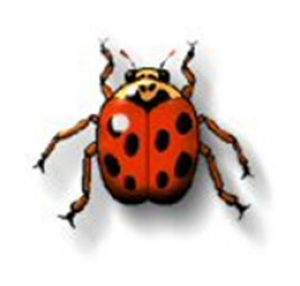

In [2]:
img = cv2.imread('korovka.jpg') 
draw_picture(img) 

In [3]:
def draw_result(pictures, number_clusters, metric_res):
    pic_box = plt.figure(figsize=(25,12))
    for i, picture in enumerate(pictures):
        picture = cv2.cvtColor(picture, cv2.COLOR_BGR2RGB)
        pic_box.add_subplot(2, 5, i+1)
        plt.title(f'Number of clusters  - {number_clusters[i]}\nSSIM - {round(metric_res[i],2)}', fontsize=20)
        plt.imshow(picture)
        plt.axis('off')
    plt.show()


def get_result_image(model, X):
    try:
        center = model.cluster_centers_
        center = np.uint8(center)
        label = model.labels_
        res = center[label.flatten()]
        return res.reshape((img.shape))
    except:
        labels = model.labels_
        center = []
        for label in np.unique(labels):
            center.append(np.mean(X[np.where(labels == label)], axis=0))
        center = np.uint8(center)
        res = center[labels.flatten()]
        return res.reshape((img.shape))

### Уменьшение палитры изображения KMeans

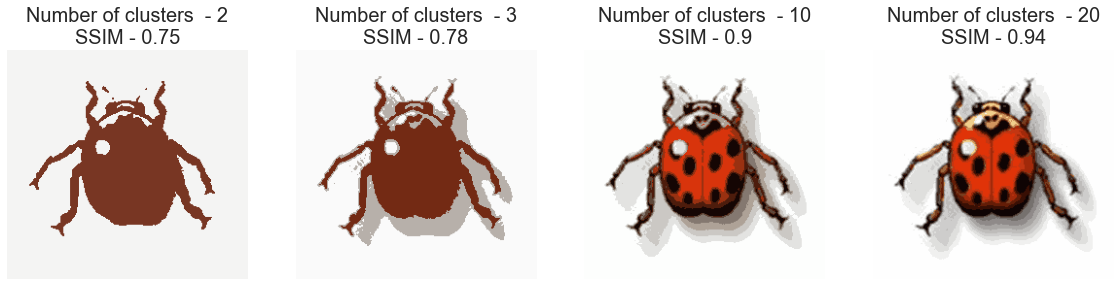

In [4]:
from sklearn.cluster import KMeans
import numpy as np

def do_KMeans(number_cluster, X):
    kmeans = KMeans(n_clusters=number_cluster).fit(X)
    result_image = get_result_image(kmeans, X)
    metrica = ssim(img, result_image, channel_axis=-1)
    metric_res_kmeans.append(metrica)
    picture_kmeans.append(result_image)

X = img.reshape((-1,3)).astype(np.float32)
number_clusters = [2, 3, 10, 20]
metric_res_kmeans = []
picture_kmeans = []
for number_cluster in number_clusters:
    do_KMeans(number_cluster, X)

draw_result(picture_kmeans, number_clusters, metric_res_kmeans)

### Уменьшение палитры изображения AgglomerativeClustering

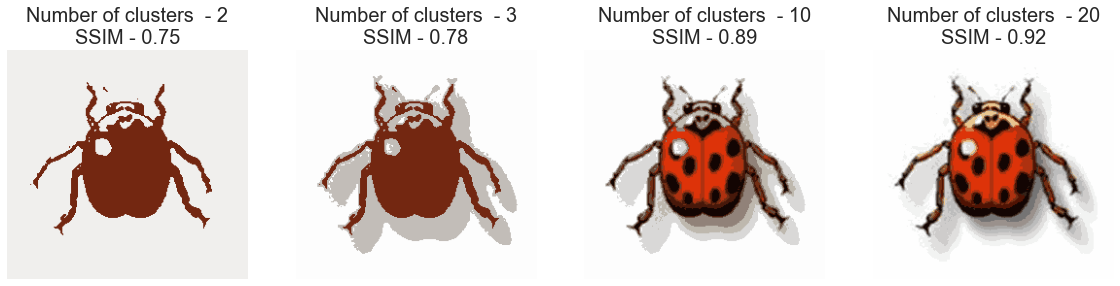

In [5]:
def do_AgglomerativeClustering(number_cluster, X):
    model = AgglomerativeClustering(n_clusters=number_cluster).fit(X)
    result_image = get_result_image(model, X)
    metrica = ssim(img, result_image, channel_axis=-1)
    metric_res_AgglomerativeClustering.append(metrica)
    picture_AgglomerativeClustering.append(result_image)
    
number_clusters = [2, 3, 10, 20]
metric_res_AgglomerativeClustering = []
picture_AgglomerativeClustering = []
for number_cluster in number_clusters:
    do_AgglomerativeClustering(number_cluster, X)

draw_result(picture_AgglomerativeClustering, number_clusters, metric_res_AgglomerativeClustering)

### Уменьшение палитры изображения DBSCAN

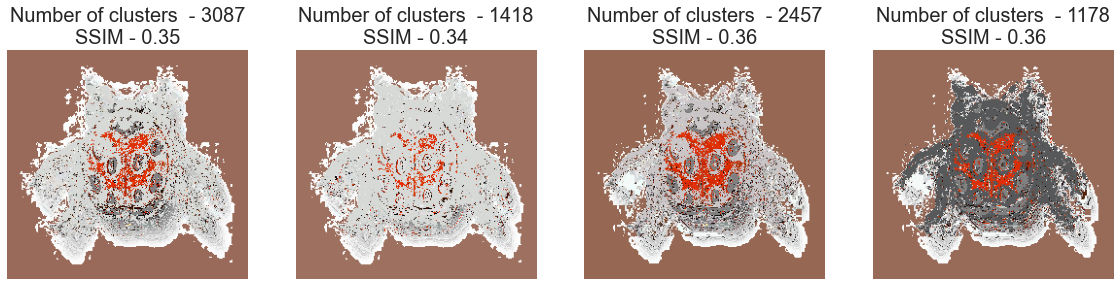

In [6]:
from sklearn.cluster import DBSCAN
def do_DBSCAN(X, min_samples=2, eps=3):
    model = DBSCAN(min_samples=min_samples, eps=eps).fit(X)
    result_image = get_result_image(model, X)
    metrica = ssim(img, result_image, channel_axis=-1)

    metric_res_DBSCAN.append(metrica)
    picture_DBSAN.append(result_image)
    number_clusters.append(len(np.unique(model.labels_)))

epss = np.arange(1, 2, 0.5)
min_sampless = np.arange(2, 4)
number_clusters = []
metric_res_DBSCAN = []
picture_DBSAN = []

for eps in epss:
    for min_sample in min_sampless:
        do_DBSCAN(X, min_sample, eps)
draw_result(picture_DBSAN,number_clusters,metric_res_DBSCAN)

### Нарисуем результат

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=[2,3,10,20], y=metric_res_kmeans, name='K_means'))
fig.add_trace(go.Scatter(x=[2,3,10,20], y=metric_res_AgglomerativeClustering, name='AgglomerativeClustering'))
fig.add_trace(go.Scatter(x=number_clusters, y=metric_res_DBSCAN, name='DBSCAN'))
fig.update_layout(title='Result SSIM',
                   xaxis_title='Number of clusters',
                   yaxis_title='SSIM')
fig.show()

Очень хорошо видно по метрике, что переход на 10 кластеров дает очень сильный прирост метрики, когда как на 20 - уже не очень. Kmeans, как мы видим, справляется лучше всех. Да и быстрее всех, на самом деле. Про DBSCAN могу сказать, что не очень хорошо он работает на цветных изображениях. Сделал я его не по кластерам, которые написаны в задании. А на те, которые получились в результате небольшого экспериментального набора. AgglomerativeClustering - очень долго работает, что неудивительно и не есть хорошо. KMEANS в уменьшении палитры цветных изображений явный лидер.

# 2 - Пишем K-Means сами

Написать K-Means и сравнить с моделькой из под sklearn.

Задание оценивается в 5 баллов

In [8]:
def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2, axis=1))

class MyKMeans:
    def __init__(self, n_clusters=10, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X_train):
        iteration = 0
        prev_centroids = None
        min_, max_ = np.min(X_train, axis=0), np.max(X_train, axis=0)
        self.centroids = [np.random.uniform(min_, max_) for _ in range(self.n_clusters)]

        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            prev_centroids = self.centroids


            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]

            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any(): 
                    self.centroids[i] = prev_centroids[i]
            iteration += 1

    def evaluate(self, X):
        centroid_idxs = []
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroid_idxs.append(centroid_idx)
        return centroid_idxs

### Создание данных

<AxesSubplot:>

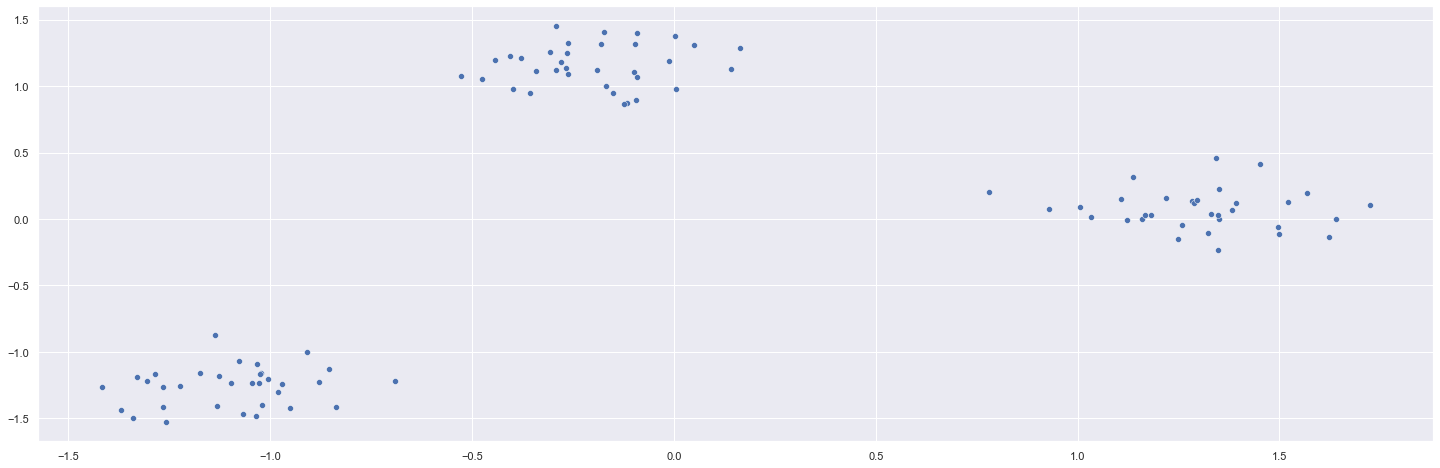

In [9]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
X_train, Y_train = make_blobs(n_samples=100, centers=3, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
sns.scatterplot(x=[x[0] for x in X_train], y=[y[1] for y in X_train])

### Обучение своей модельки и ее отрисовка

<AxesSubplot:>

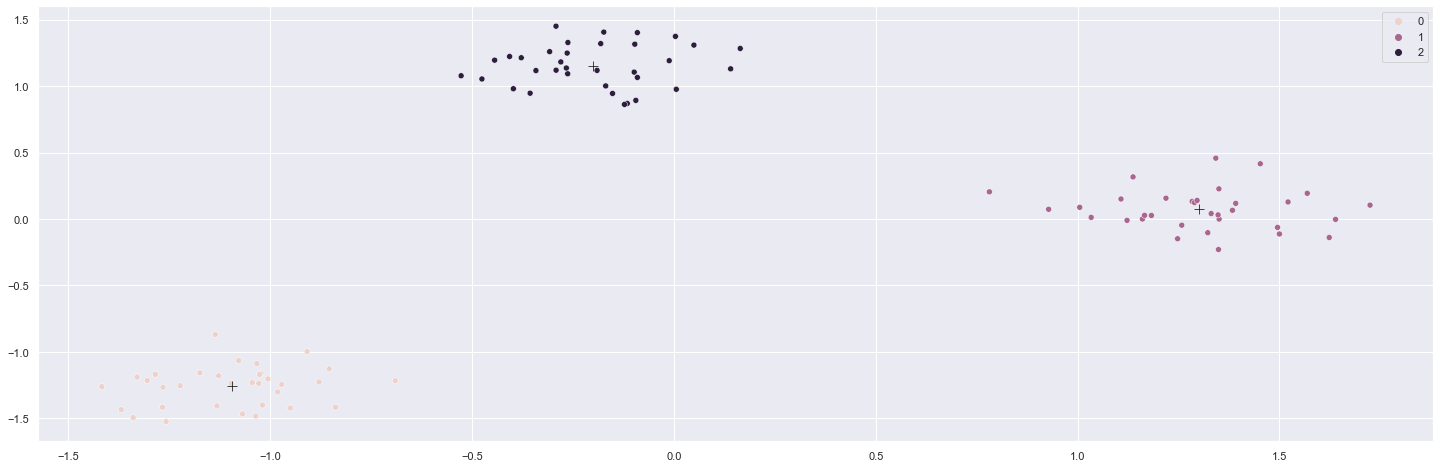

In [10]:
MyKMeans_model = MyKMeans(n_clusters=3, max_iter=400)
MyKMeans_model.fit(X_train)
y_pred_myKmeans = MyKMeans_model.evaluate(X_train)


sns.scatterplot(x=[x[0] for x in X_train], y=[y[1] for y in X_train], hue=y_pred_myKmeans)
sns.scatterplot(
         x=[x[0] for x in MyKMeans_model.centroids],
         y = [y[1] for y in MyKMeans_model.centroids],
         marker='+',
         color=".1",
         s=100)

### Обучение модельки sklearn и ее отрисовка

<AxesSubplot:>

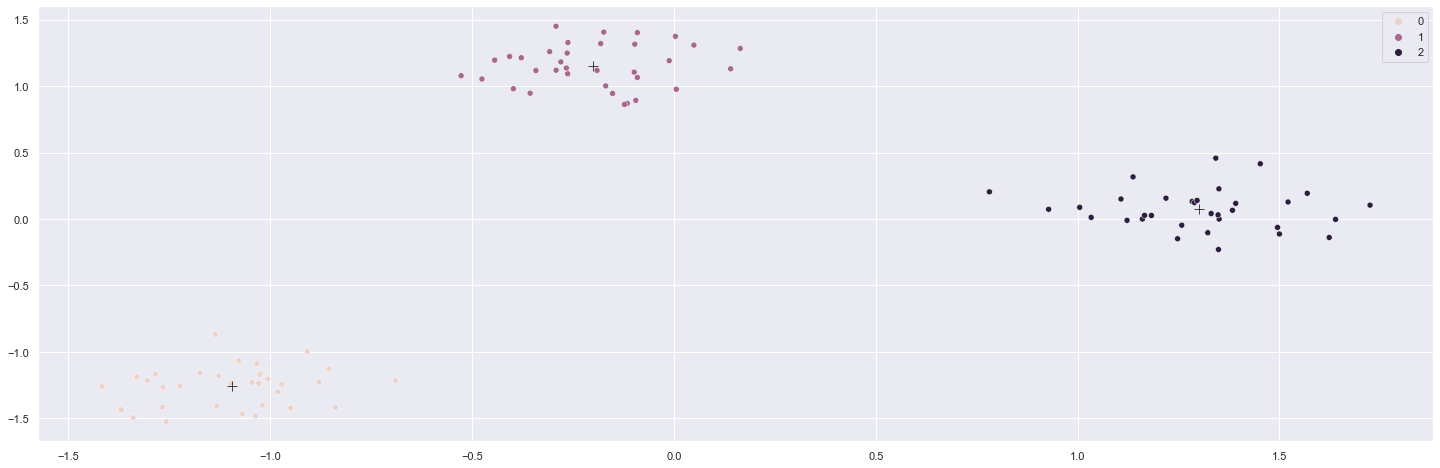

In [11]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report

KMeans_model = KMeans(n_clusters=3)
y_pred_kmeans = KMeans_model.fit_predict(X_train)
sns.scatterplot(x=[x[0] for x in X_train], y=[y[1] for y in X_train], hue=y_pred_kmeans)
sns.scatterplot(
         x=[x[0] for x in KMeans_model.cluster_centers_],
         y = [y[1] for y in KMeans_model.cluster_centers_],
         marker='+',
         color=".1",
         s=100)

### Сравнение моделек

In [12]:
print('KMeans from SKlearn')
print(classification_report(Y_train, y_pred_kmeans))
print('MyKmeans')
print(classification_report(Y_train, y_pred_myKmeans))

KMeans from SKlearn
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      34.0
           1       0.00      0.00      0.00      33.0
           2       0.00      0.00      0.00      33.0

    accuracy                           0.00     100.0
   macro avg       0.00      0.00      0.00     100.0
weighted avg       0.00      0.00      0.00     100.0

MyKmeans
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       1.00      1.00      1.00        33
           2       0.00      0.00      0.00        33

    accuracy                           0.33       100
   macro avg       0.33      0.33      0.33       100
weighted avg       0.33      0.33      0.33       100



# 3 - Пишем DBSCAN сами (дополнительное задание на 5 баллов)

Аналогично предыдудщему заданию

In [13]:
def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2, axis=0))

class My_DBSCAN():
    def __init__(self, min_samples=5, eps=0.5):
        self.min_samples = min_samples
        self.eps = eps
        self.neighbors = None
        self.clusters = []
        self.visited= None

    def find_neighbors(self, X):
        ## Построение матрицы смежности
        self.neighbors = [[] for _ in range(X.shape[0])]
        for i, x in enumerate(X):
            for j, y in enumerate(X):
                if i != j and euclidean(x, y) < self.eps:
                    self.neighbors[i].append(j)

    def create_cluster(self, X, i):
        clust = [i]
        for neighbor in self.neighbors[i]:
            if not self.visited[neighbor]:
                self.visited[neighbor] = True
                if len(self.neighbors[neighbor]) >= self.min_samples:
                    extended_clust = self.create_cluster(X, neighbor)
                    clust += extended_clust
                else:
                    clust.append(neighbor)
        return clust

    def get_labels(self, X):
        labels = np.full(shape=X.shape[0], fill_value=len(self.clusters))
        for i , cluster in enumerate(self.clusters):
            for item in cluster:
                labels[item] = i
        self.labels = labels

    def fit(self, X):
        self.visited = [False for _ in range(X.shape[0])]
        self.find_neighbors(X)

        for i in range(X.shape[0]):
            if not self.visited[i]:
                self.visited[i] = True

                if len(self.neighbors[i]) >= self.min_samples:
                    cluster = self.create_cluster(X, i)
                    self.clusters.append(cluster)

        
        self.get_labels(X)

### Создание данных

<AxesSubplot:>

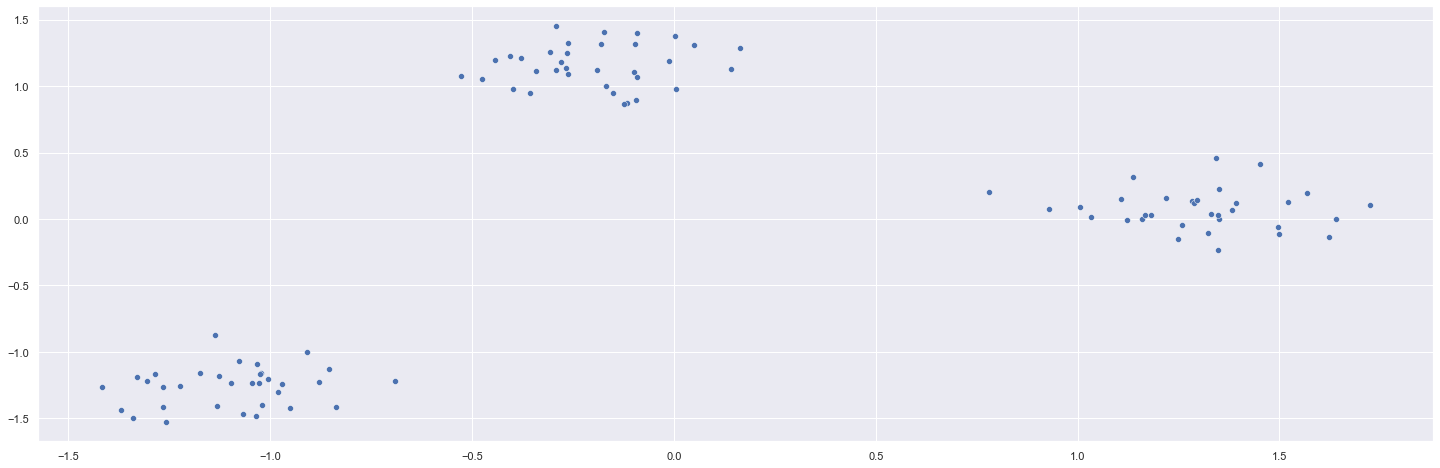

In [14]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
X_train, Y_train = make_blobs(n_samples=100, centers=3, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
sns.scatterplot(x=[x[0] for x in X_train], y=[y[1] for y in X_train])

### Обучение своей модельки

<AxesSubplot:>

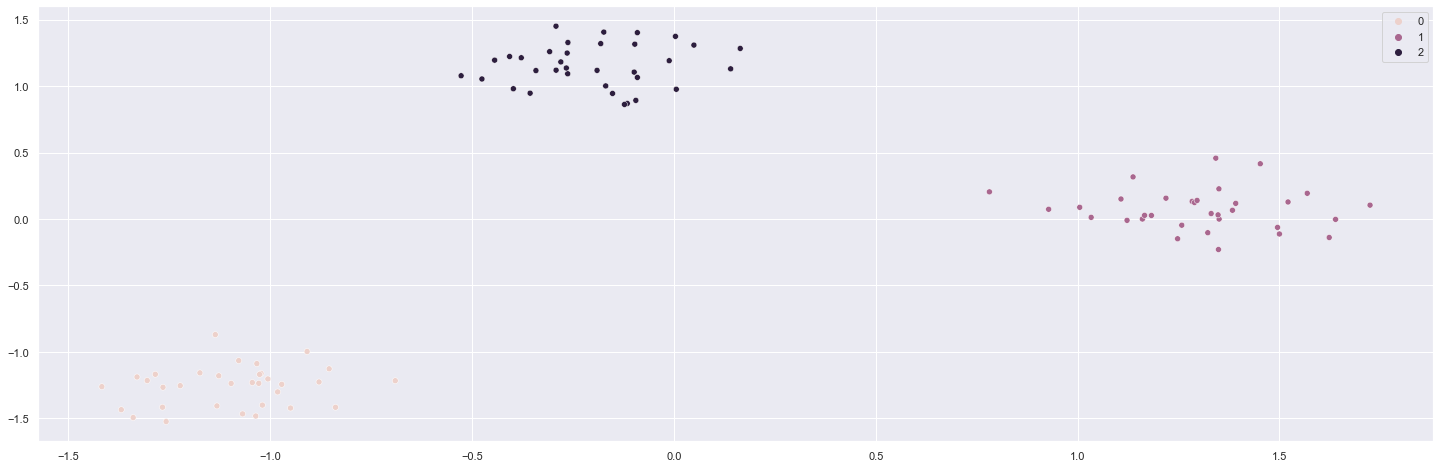

In [15]:
MyDBSCAN_model = My_DBSCAN(min_samples=5, eps=0.5)
MyDBSCAN_model.fit(X_train)
y_pred_myDBSCAN = MyDBSCAN_model.labels
sns.scatterplot(x=[x[0] for x in X_train], y=[y[1] for y in X_train], hue=y_pred_myDBSCAN)

### Обучение модельки от Sklearn

<AxesSubplot:>

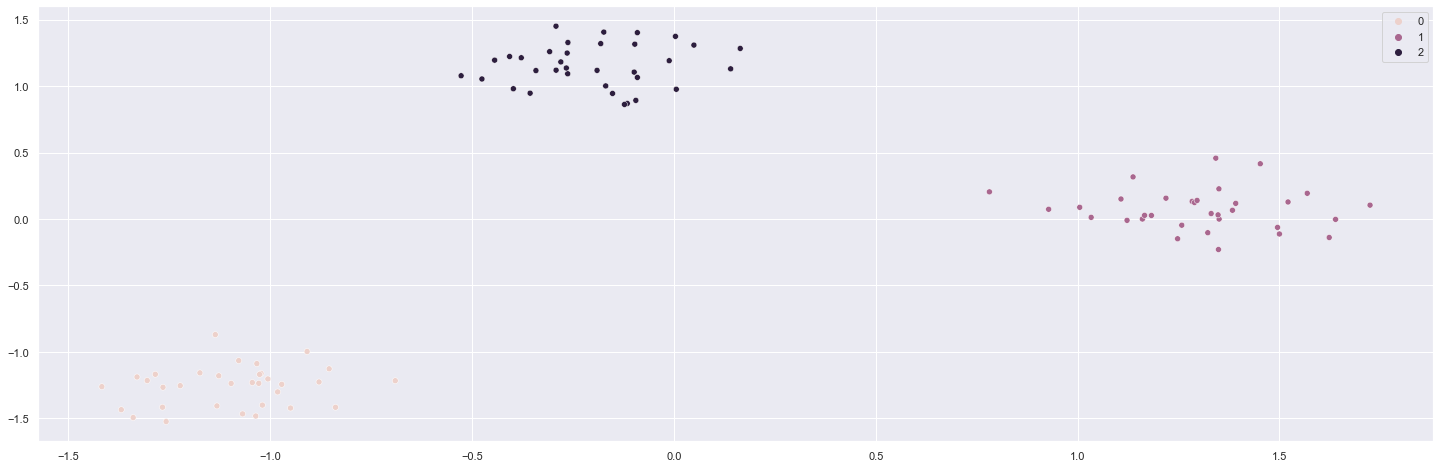

In [16]:
from sklearn.cluster import DBSCAN
SklearnDBSCAN_model = DBSCAN(min_samples=5, eps=0.5).fit(X_train)
y_pred_SklearnDBSCAN = SklearnDBSCAN_model.labels_
sns.scatterplot(x=[x[0] for x in X_train], y=[y[1] for y in X_train], hue=y_pred_SklearnDBSCAN)

### Сравнение моделек

In [17]:
from sklearn.metrics import classification_report
print('DBSCAN from SKlearn')
print(classification_report(Y_train, y_pred_SklearnDBSCAN))
print('MyDBSKAN')
print(classification_report(Y_train, y_pred_myDBSCAN))

DBSCAN from SKlearn
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       1.00      1.00      1.00        33
           2       0.00      0.00      0.00        33

    accuracy                           0.33       100
   macro avg       0.33      0.33      0.33       100
weighted avg       0.33      0.33      0.33       100

MyDBSKAN
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       1.00      1.00      1.00        33
           2       0.00      0.00      0.00        33

    accuracy                           0.33       100
   macro avg       0.33      0.33      0.33       100
weighted avg       0.33      0.33      0.33       100

